In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

In [4]:
os.chdir('data/ON_Ptax')

In [5]:
files=os.listdir()

In [6]:
excel_files = [file for file in files if '.xls' in file]

In [7]:
excel_files

['VIEWFIR2000-22.xls',
 'VIEWFIR2001-22.xls',
 'VIEWFIR2002-22.xls',
 'VIEWFIR2003-22.xls',
 'VIEWFIR2004-22.xls',
 'VIEWFIR2005-22.xls',
 'VIEWFIR2006-22.xls',
 'VIEWFIR2007-22.xls',
 'VIEWFIR2008-22.xls',
 'VIEWFIR2009-22.xls',
 'VIEWFIR2010-22.xls',
 'VIEWFIR2011-22.xlsx',
 'VIEWFIR2012-22.xlsx',
 'VIEWFIR2013-22.xlsx',
 'VIEWFIR2014-22.xlsx',
 'VIEWFIR2015-22.xlsx',
 'VIEWFIR2016-22.xlsx',
 'VIEWFIR2017-22.xlsx',
 'VIEWFIR2018-22.xlsx',
 'VIEWFIR2019-22.xlsx',
 'VIEWFIR2020-22.xlsx',
 'VIEWFIR2021-22.xlsx']

In [8]:
def df_from_excelFiles(file_name):
    file = pd.ExcelFile(file_name)
    if file_name[-1] == 'x':
        file_name = file_name[:-1]
    if int(file_name[-11:-7]) < 2009:
        name='S22-1'
        return file.parse(name, header=4, skiprows=[5])
    elif int(file_name[-11:-7]) < 2011:
        name='S22-GPL'
        return file.parse(name, header=4, skiprows=[5])
    else:
        name='SCHEDULE 22GPL'
        return file.parse(name, header=4)

In [9]:
ptax_frame = pd.concat([df_from_excelFiles(xl) for xl in excel_files])

In [10]:
ptax_frame.reset_index(inplace=True)

In [11]:
ptax_frame.head()

,index,Unnamed: 0,Year,MAH Code,Asmt Code,MunID,Municipality,UT,Tier,MSO,MPAC Population,MPAC Households,Line,Levy Area,22 Levy Area Name,RTC\nRTQ,Tax\nBand,Property Class,Tax Rate Description,Tax Ratio,% Full Rate,Taxable Assessment,LT/ST\nTax Rate,UT\nTax Rate,EDUC\nTax Rate,TOTAL\nTax Rate,LT/ST\nTaxes,UT\nTaxes,EDUC\nTaxes,TOTAL\nTaxes,Last Update,Sort,RTC,RTQ,CVA Assessment,Phase-In Taxable Assessment,RTC/RTQ
0,0,NaN,2000.0,1106.0,1999.0,20002.0,Toronto C,1.0,ST,11.0,2262100.0,943405.0,10.0,0,Toronto C,RT,0,Residential,Full occupied,1.0000,100.0,1.197768e+11,0.799702,NaN,0.414000,1.213702,957857149.0,NaN,495875788.0,1.453733e+09,2005-02-16 16:08:24,101010.0,NaN,NaN,NaN,NaN,NaN
1,1,NaN,2000.0,1106.0,1999.0,20002.0,Toronto C,1.0,ST,11.0,2262100.0,943405.0,27.0,0,Toronto C,RD,0,Residential,Education only,1.0000,100.0,2.409974e+07,NaN,NaN,0.414000,0.414000,NaN,NaN,99773.0,9.977300e+04,2005-02-16 16:08:24,101050.0,NaN,NaN,NaN,NaN,NaN
2,2,NaN,2000.0,1106.0,1999.0,20002.0,Toronto C,1.0,ST,11.0,2262100.0,943405.0,50.0,0,Toronto C,MT,0,Multi-Residential,Full occupied,5.2355,100.0,1.239037e+10,4.186840,NaN,0.414000,4.600840,518764848.0,NaN,51296120.0,5.700610e+08,2005-02-16 16:08:24,505010.0,NaN,NaN,NaN,NaN,NaN
3,3,NaN,2000.0,1106.0,1999.0,20002.0,Toronto C,1.0,ST,11.0,2262100.0,943405.0,110.0,0,Toronto C,FT,0,Farmland,Full occupied,0.2500,100.0,1.856800e+06,0.199926,NaN,0.103500,0.303426,3712.0,NaN,1922.0,5.634000e+03,2005-02-16 16:08:24,1010010.0,NaN,NaN,NaN,NaN,NaN
4,4,NaN,2000.0,1106.0,1999.0,20002.0,Toronto C,1.0,ST,11.0,2262100.0,943405.0,140.0,0,Toronto C,TT,0,Managed Forest,Full occupied,0.2500,100.0,1.099800e+05,0.199926,NaN,0.103426,0.303352,220.0,NaN,114.0,3.340000e+02,2005-02-16 16:08:24,1515010.0,NaN,NaN,NaN,NaN,NaN


In [12]:
ptax_frame.loc[ptax_frame['Year'] < 2009, 'CVA Assessment'] = ptax_frame.loc[ptax_frame['Year'] < 2009, 'Taxable Assessment']
ptax_frame.loc[ptax_frame['Year'] < 2009, 'RTC/RTQ'] = ptax_frame.loc[ptax_frame['Year'] < 2009, 'RTC\nRTQ']
ptax_frame.loc[(ptax_frame['Year'] > 2008) & (ptax_frame['Year'] < 2011), 'RTC/RTQ'] = ptax_frame.loc[(ptax_frame['Year'] > 2008) & (ptax_frame['Year'] < 2011), 'RTC'] + ptax_frame.loc[(ptax_frame['Year'] > 2008) & (ptax_frame['Year'] < 2011), 'RTQ']
ptax_frame.loc[(ptax_frame['Year'] < 2011)&(ptax_frame['Tax Rate Description'] == 'Full occupied'),'Tax Rate Description'] = 'Full Occupied'

In [13]:
ptax_frame.drop(columns=['index', 'Unnamed: 0', 'Sort', 'MPAC Population', 'MPAC Households', 'Taxable Assessment', 'RTC\nRTQ', 'RTC', 'RTQ'], inplace=True)

In [14]:
ptax_frame.rename(columns={'LT/ST\nTax Rate':'LtSt_TaxRate', 'UT\nTax Rate':'Ut_Rate', 'EDUC\nTax Rate':'Education_Rate', 'TOTAL\nTax Rate':'Total_TaxRate'}, inplace=True)

In [15]:
ptax_frame.loc[ptax_frame['Year'] < 2011, ['LtSt_TaxRate','Ut_Rate','Education_Rate', 'Total_TaxRate']] = ptax_frame.loc[ptax_frame['Year'] < 2011, ['LtSt_TaxRate','Ut_Rate','Education_Rate', 'Total_TaxRate']] * 0.01 

In [16]:
ptax_frame.loc[ptax_frame['Municipality'] == 'Markham T', 'Municipality'] = 'Markham C'

In [17]:
Durham = ['Durham R','Ajax T', 'Clarington M', 'Brock Tp', 'Oshawa C', 'Pickering C', 'Scugog Tp', 'Uxbridge Tp', 'Whitby T']
Halton = ['Halton R', 'Burlington C', 'Halton Hills T', 'Milton T', 'Oakville T']
Peel = ['Peel R', 'Brampton C', 'Mississauga C', 'Caledon T']
York = ['York R', 'Vaughan C', 'Markham C', 'Richmond Hill C', 'Aurora T', 'Newmarket T', 'Whitchurch-Stouffville T', 'East Gwillimbury T', 'Georgina T', 'King Tp']
Dufferin = ['Mono T', 'Orangeville T']
Simcoe = ['Bradford West Gwillimbury T', 'New Tecumseth T']
Toronto = ['Toronto C']

In [18]:
GTA = Durham + Halton + Peel + York + Dufferin + Simcoe + Toronto

In [19]:
gta_ptax_frame = ptax_frame[ptax_frame['Municipality'].isin(GTA)]

In [20]:
pclasses = ['Residential', 'Commercial', 'Industrial', 'Large Industrial', 'Multi-Residential', 'Farmland', 'Managed Forest', 'Pipeline']

In [21]:
gta_ptax_frame = gta_ptax_frame[(gta_ptax_frame['Property Class'].isin(pclasses)) & (gta_ptax_frame['Tax Rate Description'] == 'Full Occupied')].copy()

In [22]:
upper_tier = ['York R', 'Halton R', 'Peel R', 'Durham R']

In [23]:
gta_sL_ptax= gta_ptax_frame[~gta_ptax_frame.Municipality.isin(upper_tier)]
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Durham),['Region']] = 'Durham R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(York),['Region']] = 'York R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Peel),['Region']] = 'Peel R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Halton),['Region']] = 'Halton R'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Dufferin),['Region']] = 'Dufferin Co'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Simcoe),['Region']] = 'Simcoe Co'
gta_sL_ptax.loc[gta_sL_ptax['Municipality'].isin(Toronto),['Region']] = 'Toronto C'

In [24]:
gta_sL_ptax.columns

Index(['Year', 'MAH Code', 'Asmt Code', 'MunID', 'Municipality', 'UT', 'Tier',
       'MSO', 'Line', 'Levy Area', '22 Levy Area Name', 'Tax\nBand',
       'Property Class', 'Tax Rate Description', 'Tax Ratio', '% Full Rate',
       'LtSt_TaxRate', 'Ut_Rate', 'Education_Rate', 'Total_TaxRate',
       'LT/ST\nTaxes', 'UT\nTaxes', 'EDUC\nTaxes', 'TOTAL\nTaxes',
       'Last Update', 'CVA Assessment', 'Phase-In Taxable Assessment',
       'RTC/RTQ', 'Region'],
      dtype='object')

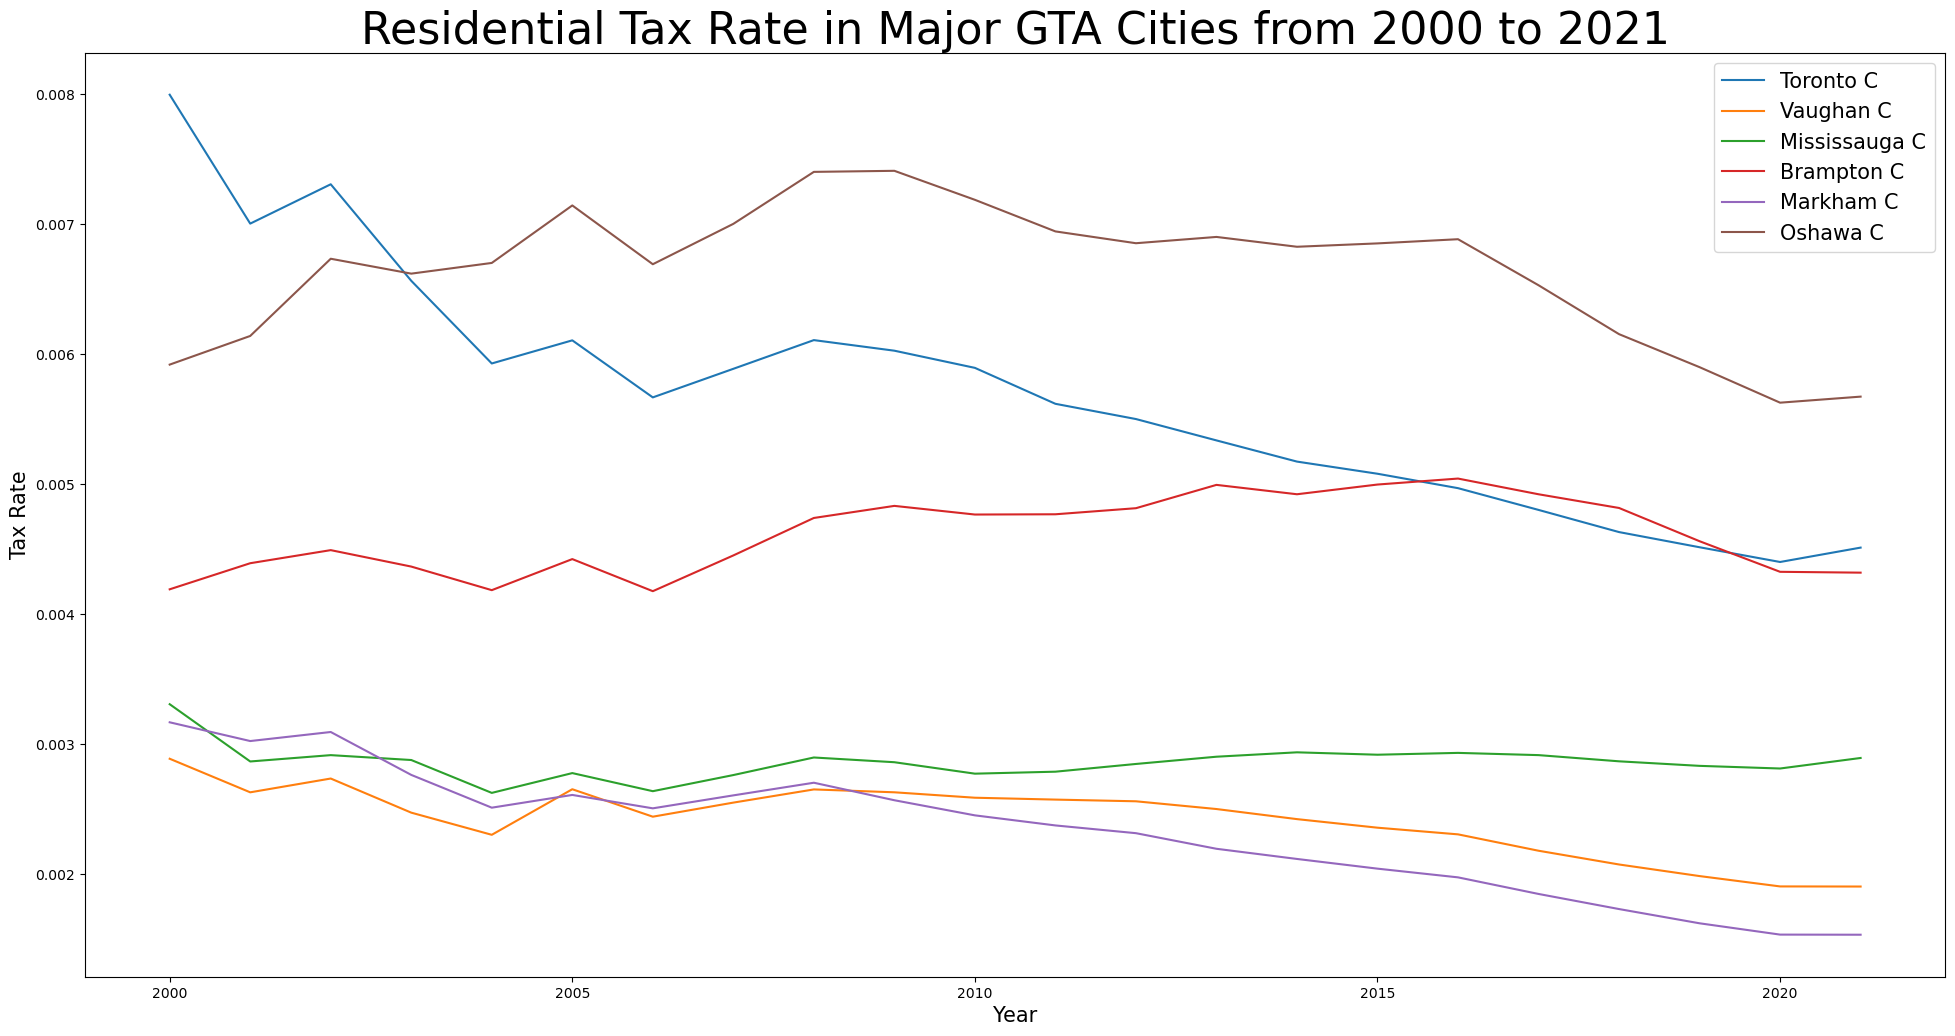

In [25]:
cities = ['Toronto C', 'Vaughan C', 'Mississauga C', 'Brampton C', 'Markham C', 'Oshawa C']
data = gta_sL_ptax[(gta_sL_ptax['Municipality'].isin(cities)) & (gta_sL_ptax['Property Class'] == 'Residential')]
plt.figure(figsize=(24,12))
for city in cities:
    plt.plot(data[data['Municipality'] == city]['Year'], data[data['Municipality'] == city]['LtSt_TaxRate'], label=city)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Tax Rate', fontsize=15)
plt.title('Residential Tax Rate in Major GTA Cities from 2000 to 2021', fontsize=32)
plt.legend(prop={'size':15})
plt.show()

I wanted to look at a comparison of Residential tax rates across different GTA municipalities from 2000-2021.  The result was the misleading chart below.  Here it looks like Toronto residential tax rate starts out as the highest in 2000 and then declines somewhat such that it ends up below Oshawa and just ahead of Brampton in 2021.

What this does not take into account, however, is that all of the municipalities other than Toronto also add a upper tier residential tax rate.  The next chart shows that when we switch to the total Residential tax rate (the educational tax rate is included but this is the same across all municipalities).  We can see that Toronto actually has the lowest effective residential tax rate throughout the entire period

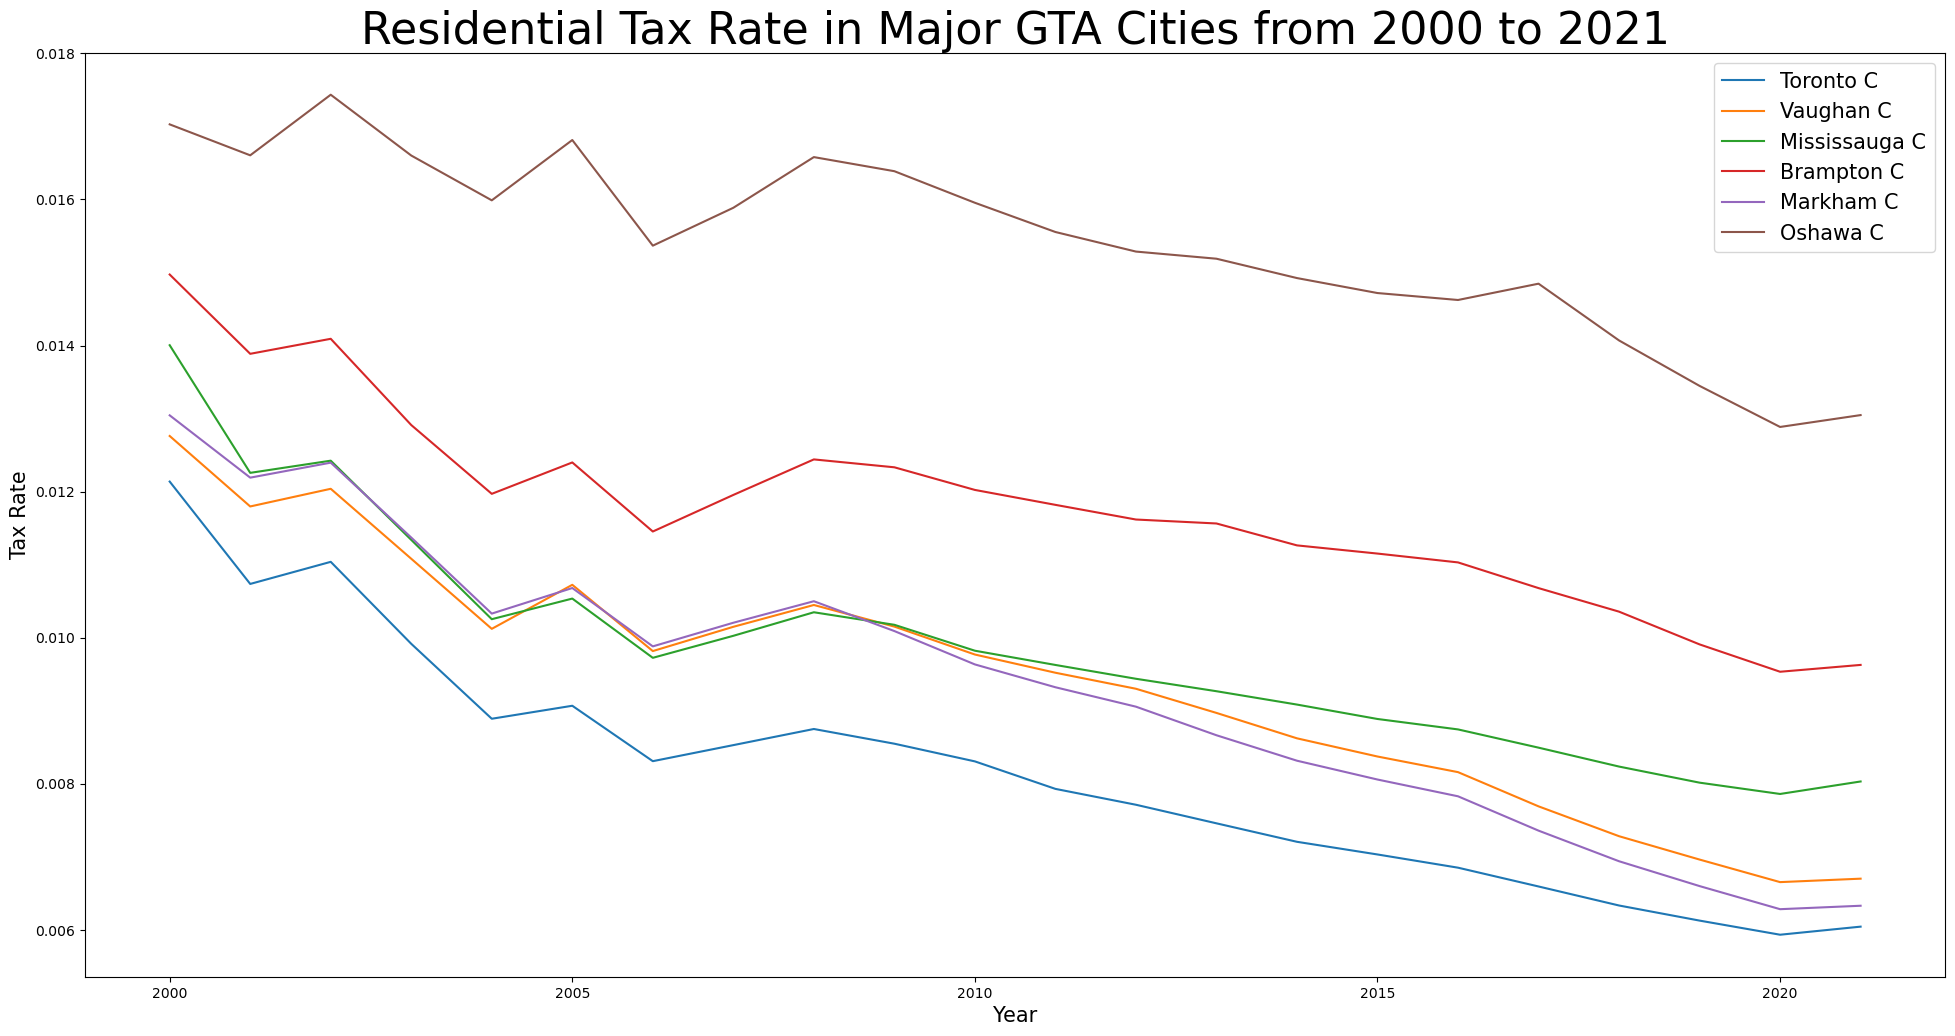

In [26]:
cities = ['Toronto C', 'Vaughan C', 'Mississauga C', 'Brampton C', 'Markham C', 'Oshawa C']
data = gta_sL_ptax[(gta_sL_ptax['Municipality'].isin(cities)) & (gta_sL_ptax['Property Class'] == 'Residential')]
plt.figure(figsize=(24,12))
for city in cities:
    plt.plot(data[data['Municipality'] == city]['Year'], data[data['Municipality'] == city]['Total_TaxRate'], label=city)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Tax Rate', fontsize=15)
plt.title('Residential Tax Rate in Major GTA Cities from 2000 to 2021', fontsize=32)
plt.legend(prop={'size':15})
plt.show()

There is something very interesting in the chart above.  It seems very counter intuitive as it shows that property taxation rates for the Residential property class has tended to decline in all of the large cities in the GTA.  How can this be?  Are we not constantly hearing that property taxes are going up?

Using the example of Toronto, the chart below tries to make sense of this puzzle.

In [27]:
data = gta_sL_ptax[(gta_sL_ptax['Municipality'] == 'Toronto C') & (gta_sL_ptax['Property Class'] == 'Residential')][['Year','CVA Assessment',      'Phase-In Taxable Assessment','LtSt_TaxRate','Education_Rate', 'Total_TaxRate', 'LT/ST\nTaxes', 'EDUC\nTaxes', 'TOTAL\nTaxes']]

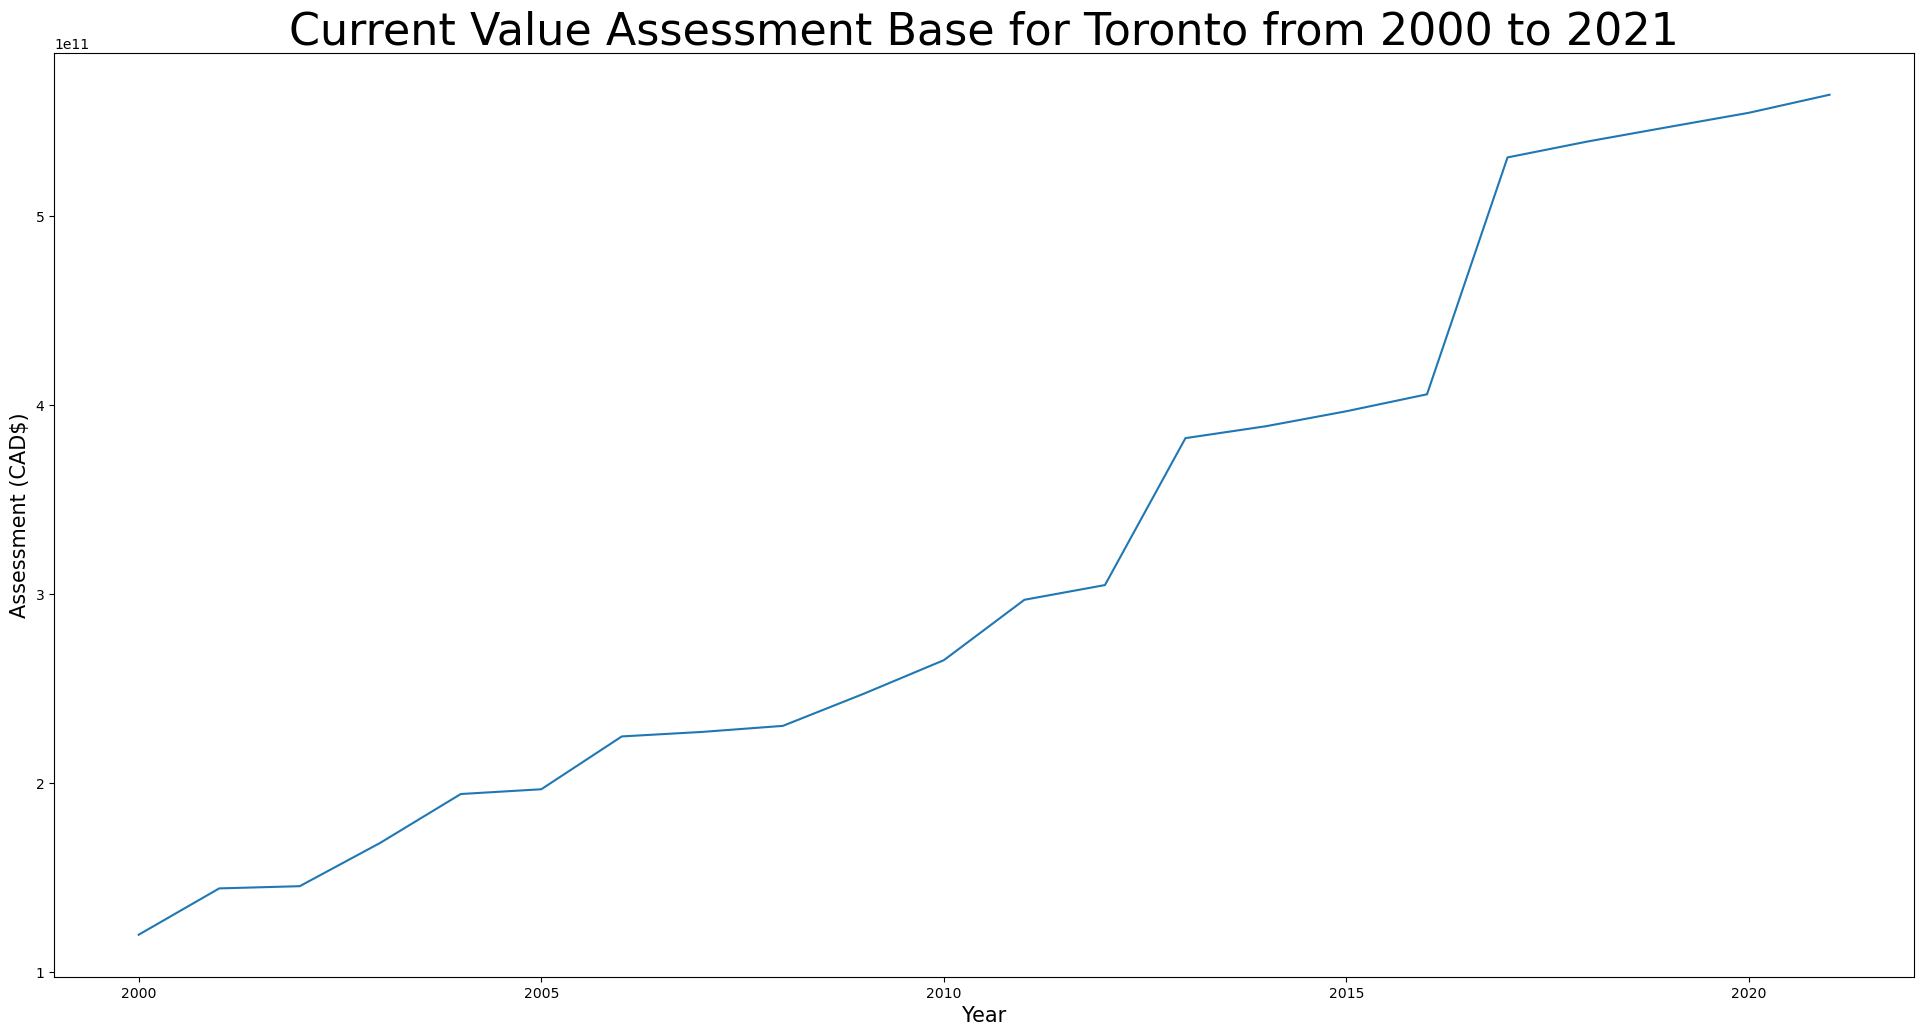

In [28]:
data = gta_sL_ptax[(gta_sL_ptax['Municipality'] == 'Toronto C') & (gta_sL_ptax['Property Class'] == 'Residential')][['Year','CVA Assessment',      'Phase-In Taxable Assessment','LtSt_TaxRate','Education_Rate', 'Total_TaxRate', 'LT/ST\nTaxes', 'EDUC\nTaxes', 'TOTAL\nTaxes']]

plt.figure(figsize=(24,12))
plt.plot(data['Year'], data['CVA Assessment'])
plt.xlabel('Year', fontsize=15)
plt.ylabel('Assessment (CAD$)', fontsize=15)
plt.title('Current Value Assessment Base for Toronto from 2000 to 2021', fontsize=32)
plt.show()

In the chart above we can see that the assessment base for Toronto has grown at a rapid rate from 2011 to 2012.  What this show is that the increase in property taxes that people experience can be attributed to the increase in property prices.  Municipalities set their tax rates in response to two key elements - 1. the total expected costs for the year 2. the total value of the assessment base.  Given the fact that property prices are pushing upward, it seems that there has been a trend for municipal tax rates in the residential class to decline.

One should note that there are large increases in the tax base in 2012 and 2016 respectively followed by periods of more gradual growth.  These large jumps are due to province-wide MPAC property assessments that are done on a 4-year schedule.  Due to the COVID-19 pandemic the MPAC assessment scheduled for 2020 has been postponed.

(add different perspectives on return to assessment cycle)

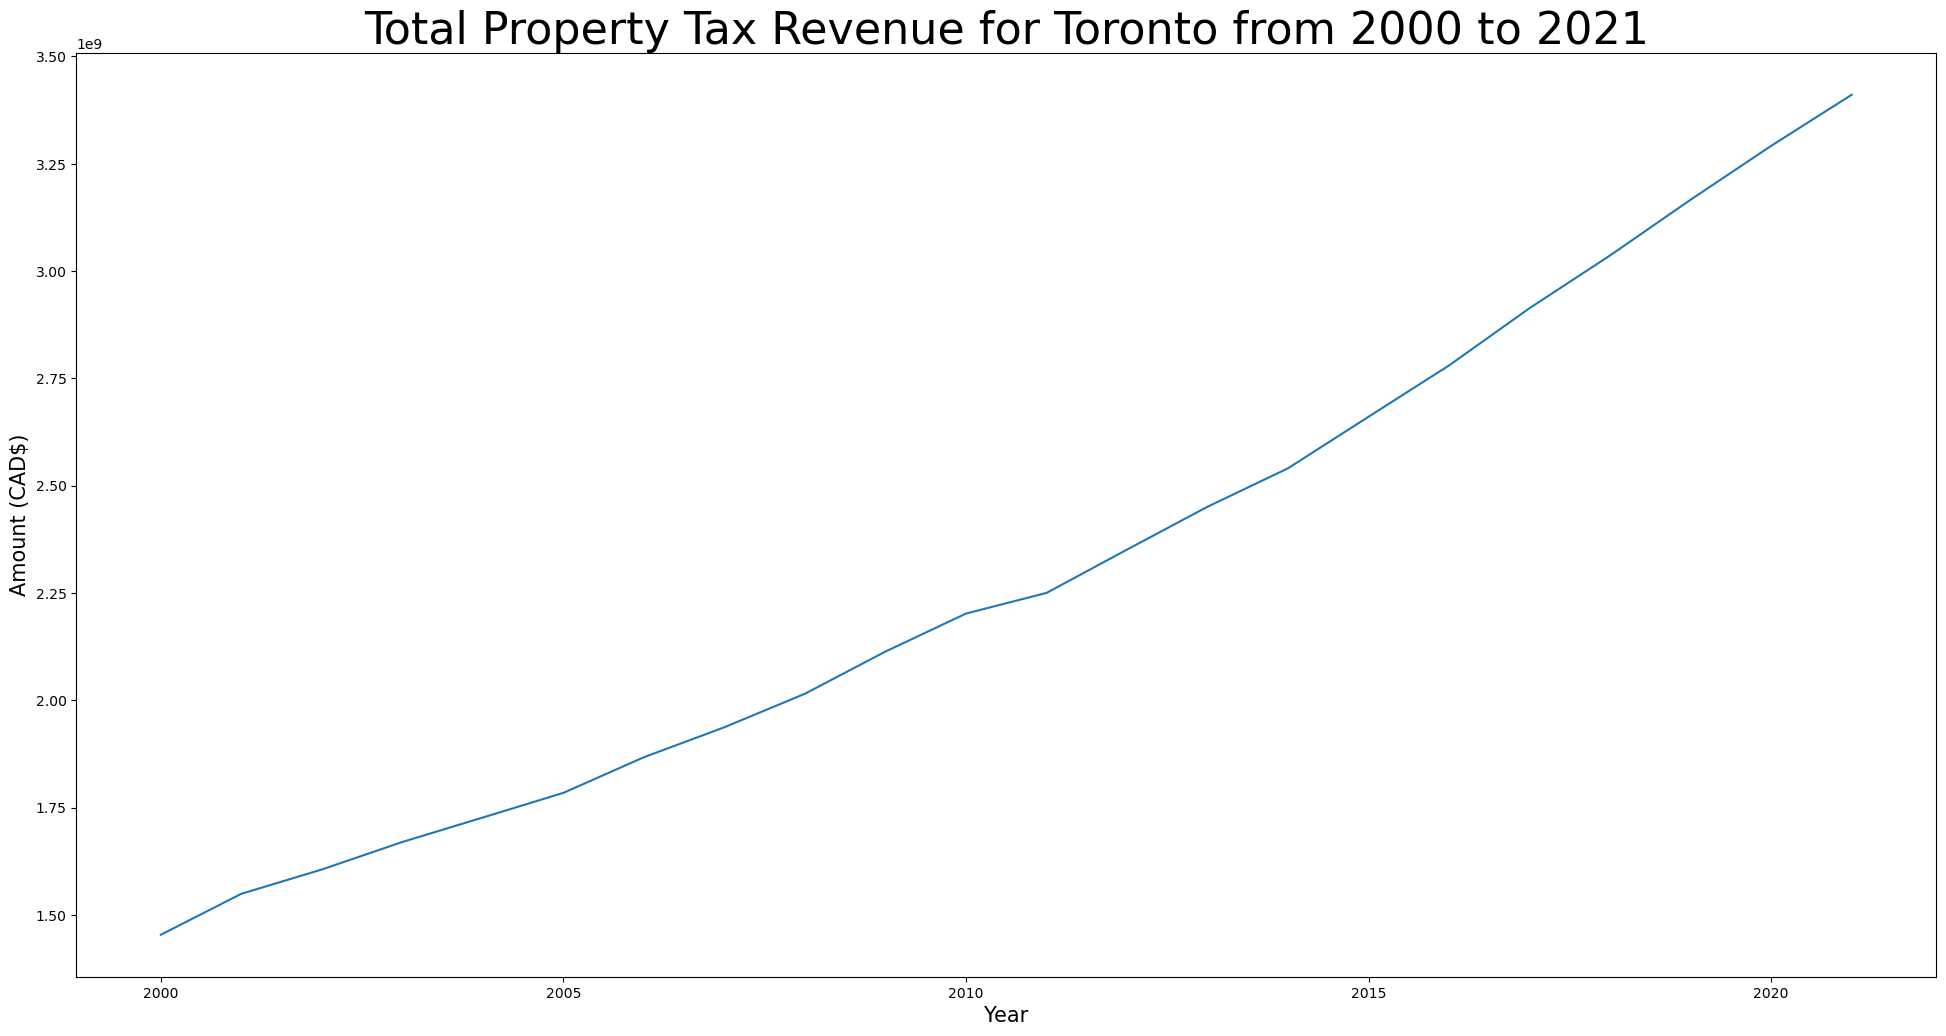

In [29]:
data = gta_sL_ptax[(gta_sL_ptax['Municipality'] == 'Toronto C') & (gta_sL_ptax['Property Class'] == 'Residential')][['Year','CVA Assessment', 'Phase-In Taxable Assessment','LtSt_TaxRate','Education_Rate', 'Total_TaxRate', 'LT/ST\nTaxes', 'EDUC\nTaxes', 'TOTAL\nTaxes']]
plt.figure(figsize=(24,12))
plt.plot(data['Year'], data['TOTAL\nTaxes'])
plt.xlabel('Year', fontsize=15)
plt.ylabel('Amount (CAD$)', fontsize=15)
plt.title('Total Property Tax Revenue for Toronto from 2000 to 2021', fontsize=32)
plt.show()

Here I look at how commercial property tax rates changed across some of the larger municipalities in the GTA between 2000-2021.

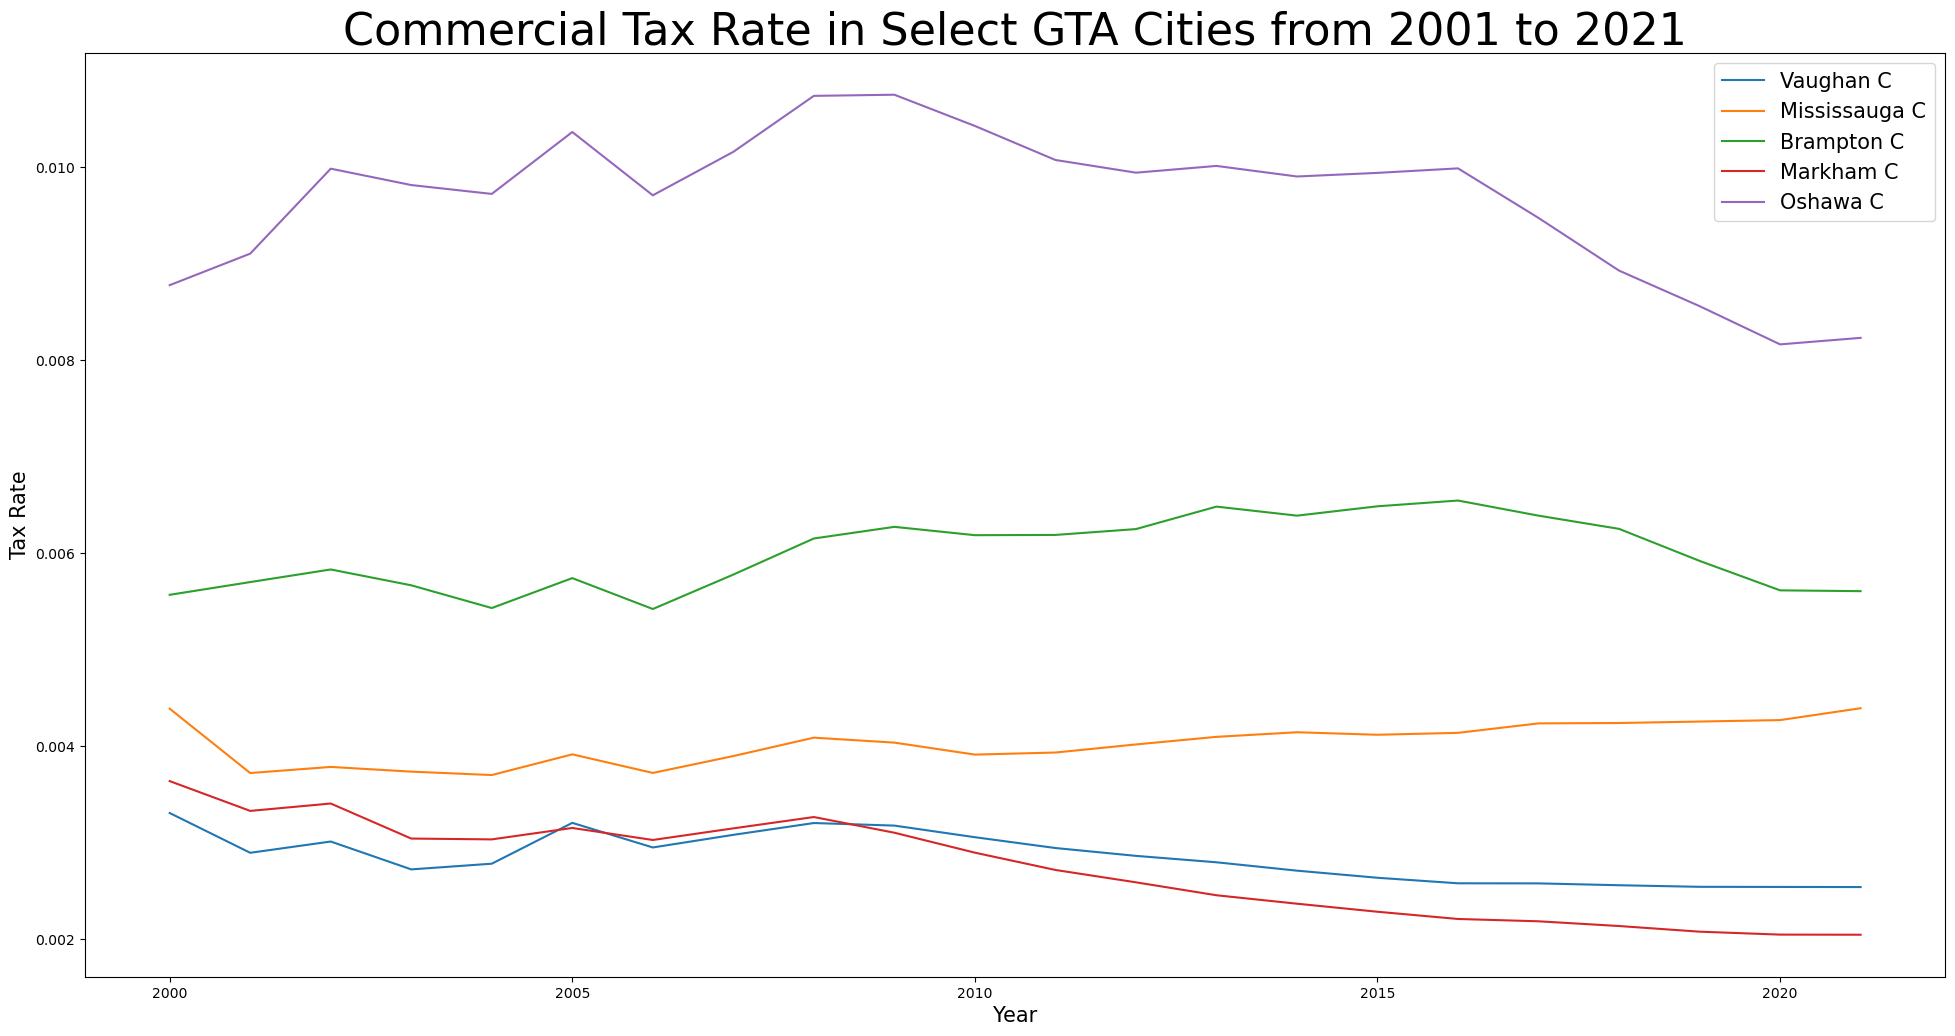

In [30]:
cities = ['Vaughan C', 'Mississauga C', 'Brampton C', 'Markham C', 'Oshawa C']
data = gta_sL_ptax[(gta_sL_ptax['Municipality'].isin(cities)) & (gta_sL_ptax['Property Class'] == 'Commercial')]
plt.figure(figsize=(24,12))
for city in cities:
    plt.plot(data[data['Municipality'] == city]['Year'], data[data['Municipality'] == city]['LtSt_TaxRate'], label=city)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Tax Rate', fontsize=15)
plt.title('Commercial Tax Rate in Select GTA Cities from 2001 to 2021', fontsize=32)
plt.legend(prop={'size':15})
plt.show()

I also wanted to include Toronto in this comparison.  However, it required some additional work.  Since 2009, Toronto has had two commercial tax rates - a lower band for small businesses and a higher band for all other businesses.

The question then was how to arrive at a single commercial tax rate for each year.  I thought about simply using an average of the upper & lower band for each year.  However, this would not be exactly accurate.

Instead, I found a better method.  Graduated tax banding is revenue neutral.  Therefore any reduction in total tax revenue from lower band rate must be made up by a corresponding increase in the upper band.  With this in mind, I simply totaled the total tax revenue from each band along with the total assessment from both bands and then divided the total tax revenue for all commercial properties by the total commercial assessment.

C:\Users\david\AppData\Local\Temp\ipykernel_45100\3216667005.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  toronto_data.drop(toronto_data.loc[toronto_data['Tax\nBand'] == 'L'].index, inplace=True)
C:\Users\david\AppData\Local\Temp\ipykernel_45100\3216667005.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = data.append(toronto_data)


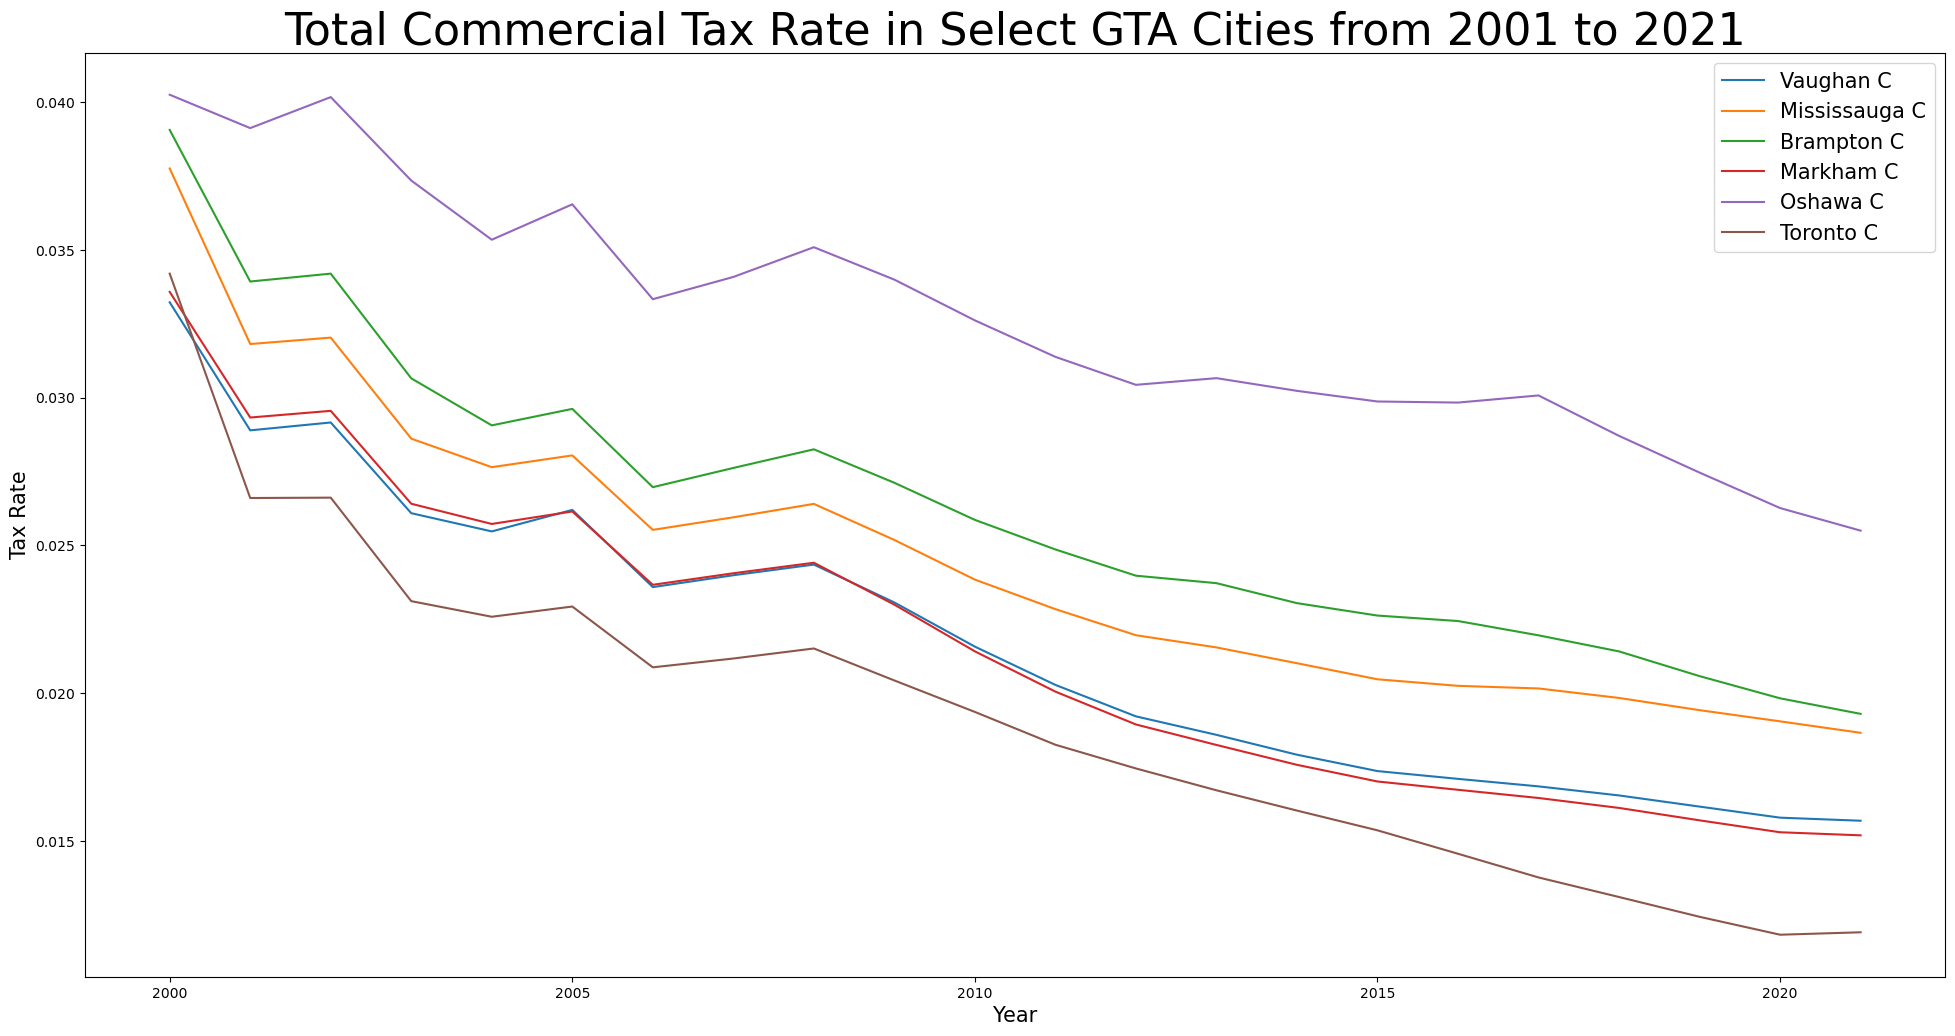

In [31]:
cities = ['Vaughan C', 'Mississauga C', 'Brampton C', 'Markham C', 'Oshawa C']
data = gta_sL_ptax[(gta_sL_ptax['Municipality'].isin(cities)) & (gta_sL_ptax['Property Class'] == 'Commercial')]

toronto_data = gta_sL_ptax[(gta_sL_ptax['Municipality'] == 'Toronto C') & (gta_sL_ptax['Property Class'] == 'Commercial')]
aCVA = gta_sL_ptax.loc[(gta_sL_ptax['Property Class'] == 'Commercial') & (gta_sL_ptax['Year'] > 2008) & (gta_sL_ptax['Tax\nBand'] == 'H'), 'CVA Assessment']
bCVA = gta_sL_ptax.loc[(gta_sL_ptax['Property Class'] == 'Commercial') & (gta_sL_ptax['Year'] > 2008) & (gta_sL_ptax['Tax\nBand'] == 'L'), 'CVA Assessment']

aTotTax = gta_sL_ptax.loc[(gta_sL_ptax['Property Class'] == 'Commercial') & (gta_sL_ptax['Year'] > 2008) & (gta_sL_ptax['Tax\nBand'] == 'H'), 'TOTAL\nTaxes']
bTotTax = gta_sL_ptax.loc[(gta_sL_ptax['Property Class'] == 'Commercial') & (gta_sL_ptax['Year'] > 2008) & (gta_sL_ptax['Tax\nBand'] == 'L'), 'TOTAL\nTaxes']

TotCVA = pd.Series(aCVA.values + bCVA.values, index=aCVA.index)
TotTax = pd.Series(aTotTax.values + bTotTax.values, index=aTotTax.index)
CommRate = pd.Series(TotTax.values/TotCVA.values, index=TotTax.index)

toronto_data.loc[(toronto_data['Property Class'] == 'Commercial') & (toronto_data['Year'] > 2008) & (toronto_data['Tax\nBand'] == 'H'), 'Total_TaxRate'] = CommRate
toronto_data.drop(toronto_data.loc[toronto_data['Tax\nBand'] == 'L'].index, inplace=True)

data = data.append(toronto_data)

plt.figure(figsize=(24,12))
for city in cities:
    plt.plot(data[data['Municipality'] == city]['Year'], data[data['Municipality'] == city]['Total_TaxRate'], label=city)
plt.plot(data[data['Municipality'] == 'Toronto C']['Year'], data[data['Municipality'] == 'Toronto C']['LtSt_TaxRate'], label='Toronto C')
plt.xlabel('Year', fontsize=15)
plt.ylabel('Tax Rate', fontsize=15)
plt.title('Total Commercial Tax Rate in Select GTA Cities from 2001 to 2021', fontsize=32)
plt.legend(prop={'size':15})
plt.show()

In [32]:
gta_sL_ptax[(gta_sL_ptax['Municipality'] == 'Toronto C') & (gta_ptax_frame['Year'] ==2007) & (gta_ptax_frame['Property Class'] == 'Commercial')]

C:\Users\david\AppData\Local\Temp\ipykernel_45100\1687518166.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  gta_sL_ptax[(gta_sL_ptax['Municipality'] == 'Toronto C') & (gta_ptax_frame['Year'] ==2007) & (gta_ptax_frame['Property Class'] == 'Commercial')]


,Year,MAH Code,Asmt Code,MunID,Municipality,UT,Tier,MSO,Line,Levy Area,22 Levy Area Name,Tax\nBand,Property Class,Tax Rate Description,Tax Ratio,% Full Rate,LtSt_TaxRate,Ut_Rate,Education_Rate,Total_TaxRate,LT/ST\nTaxes,UT\nTaxes,EDUC\nTaxes,TOTAL\nTaxes,Last Update,CVA Assessment,Phase-In Taxable Assessment,RTC/RTQ,Region
48071,2007.0,1106.0,1999.0,20002.0,Toronto C,1.0,ST,11.0,210.0,0,Toronto C,0,Commercial,Full Occupied,3.67373,100.0,0.021175,NaN,0.019758,0.040933,589130901.0,NaN,549724260.0,1.138855e+09,2008-10-31 18:00:00,2.782257e+10,NaN,CT,Toronto C


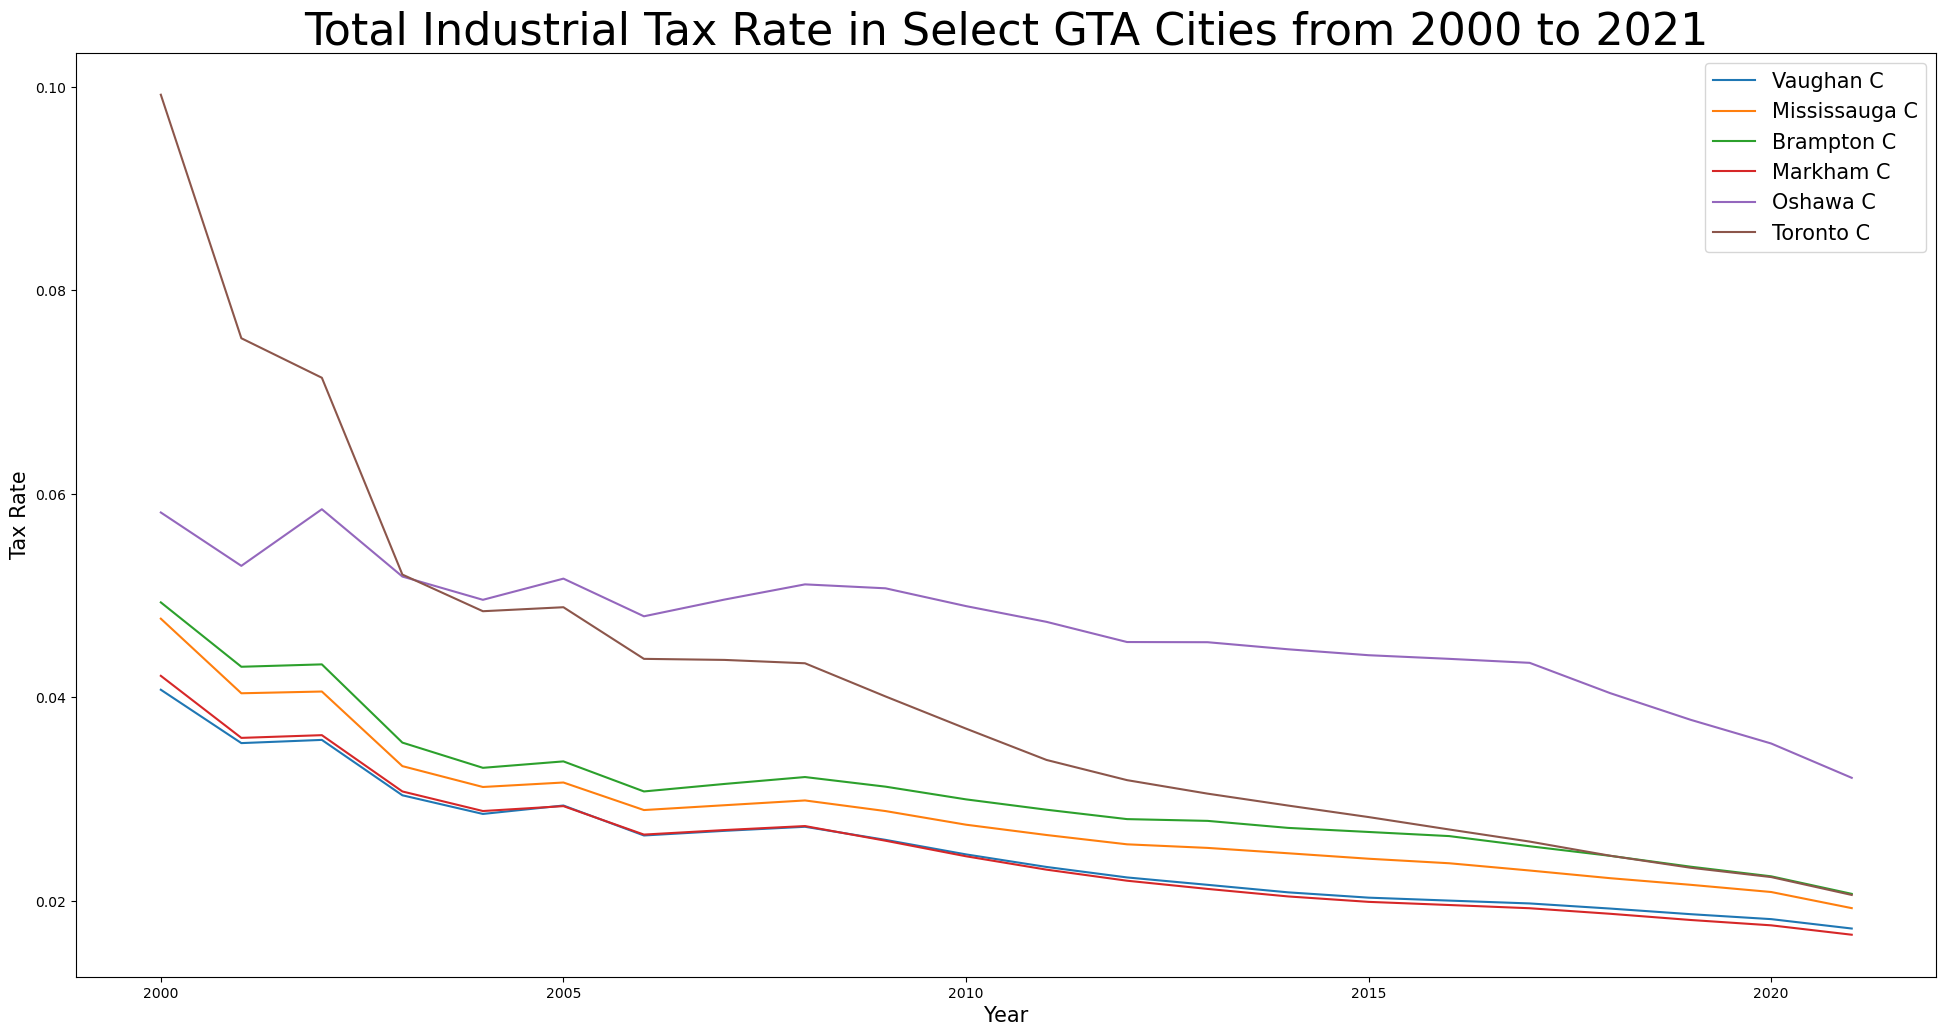

In [33]:
cities = ['Vaughan C', 'Mississauga C', 'Brampton C', 'Markham C', 'Oshawa C', 'Toronto C']
data = gta_sL_ptax[(gta_sL_ptax['Municipality'].isin(cities)) & (gta_sL_ptax['Property Class'] == 'Industrial')]
plt.figure(figsize=(24,12))
for city in cities:
    plt.plot(data[data['Municipality'] == city]['Year'], data[data['Municipality'] == city]['Total_TaxRate'], label=city)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Tax Rate', fontsize=15)
plt.title('Total Industrial Tax Rate in Select GTA Cities from 2000 to 2021', fontsize=32)
plt.legend(prop={'size':15})
plt.show()

In [34]:
ptax_frame[ptax_frame['Property Class'].isin(pclasses)]

,Year,MAH Code,Asmt Code,MunID,Municipality,UT,Tier,MSO,Line,Levy Area,22 Levy Area Name,Tax\nBand,Property Class,Tax Rate Description,Tax Ratio,% Full Rate,LtSt_TaxRate,Ut_Rate,Education_Rate,Total_TaxRate,LT/ST\nTaxes,UT\nTaxes,EDUC\nTaxes,TOTAL\nTaxes,Last Update,CVA Assessment,Phase-In Taxable Assessment,RTC/RTQ
0,2000.0,1106.0,1999.0,20002.0,Toronto C,1.0,ST,11.0,10.0,0,Toronto C,0,Residential,Full Occupied,1.0000,100.00,0.007997,NaN,0.004140,0.012137,957857149.0,NaN,495875788.0,1.453733e+09,2005-02-16 16:08:24,1.197768e+11,NaN,RT
1,2000.0,1106.0,1999.0,20002.0,Toronto C,1.0,ST,11.0,27.0,0,Toronto C,0,Residential,Education only,1.0000,100.00,NaN,NaN,0.004140,0.004140,NaN,NaN,99773.0,9.977300e+04,2005-02-16 16:08:24,2.409974e+07,NaN,RD
2,2000.0,1106.0,1999.0,20002.0,Toronto C,1.0,ST,11.0,50.0,0,Toronto C,0,Multi-Residential,Full Occupied,5.2355,100.00,0.041868,NaN,0.004140,0.046008,518764848.0,NaN,51296120.0,5.700610e+08,2005-02-16 16:08:24,1.239037e+10,NaN,MT
3,2000.0,1106.0,1999.0,20002.0,Toronto C,1.0,ST,11.0,110.0,0,Toronto C,0,Farmland,Full Occupied,0.2500,100.00,0.001999,NaN,0.001035,0.003034,3712.0,NaN,1922.0,5.634000e+03,2005-02-16 16:08:24,1.856800e+06,NaN,FT
4,2000.0,1106.0,1999.0,20002.0,Toronto C,1.0,ST,11.0,140.0,0,Toronto C,0,Managed Forest,Full Occupied,0.2500,100.00,0.001999,NaN,0.001034,0.003034,220.0,NaN,114.0,3.340000e+02,2005-02-16 16:08:24,1.099800e+05,NaN,TT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278134,2021.0,37605.0,3227.0,32027.0,Zorra Tp,37.0,LT,15.0,515.0,0,Zorra Tp,0,Industrial,"Full Occupied, Shared PIL",2.6300,1.00,0.013759,0.009653,0.012500,0.035912,8523.0,5980.0,7744.0,2.224700e+04,2022-09-30 00:00:00,6.195000e+05,619500.0,IH
278135,2021.0,37605.0,3227.0,32027.0,Zorra Tp,37.0,LT,15.0,540.0,0,Zorra Tp,0,Industrial,Excess Land,2.6300,0.65,0.008943,0.006274,0.008800,0.024018,10453.0,7334.0,10286.0,2.807300e+04,2022-09-30 00:00:00,1.168855e+06,1168855.0,IU
278136,2021.0,37605.0,3227.0,32027.0,Zorra Tp,37.0,LT,15.0,570.0,0,Zorra Tp,0,Industrial,Vacant Land,2.6300,0.65,0.008943,0.006274,0.008800,0.024018,2743.0,1924.0,2699.0,7.366000e+03,2022-09-30 00:00:00,3.067000e+05,306700.0,IX
278137,2021.0,37605.0,3227.0,32027.0,Zorra Tp,37.0,LT,15.0,610.0,0,Zorra Tp,0,Large Industrial,Full Occupied,2.6300,1.00,0.013759,0.009653,0.008800,0.032212,137225.0,96278.0,87769.0,3.212720e+05,2022-09-30 00:00:00,9.973800e+06,9973800.0,LT
